# Using El Nino Southern Oscillation (ENSO) Information To Predict Water Levels in Norfolk, VA

## Introduction and Motivation: 

Large-scale atmospheric and oceanic dynamics can have global reach, although detecting the effects of these phenomena becomes more complicated as one moves further away from the phenomenas' locations of origin. As a consequence we would expect to see time lags between the moment when large-scale dynamics are observed, and when their affects become apparent at distant locations. When present, these lags can enable forecasters to generate meaningful predictions for distant locations in time for policymakers to work toward increased resilience by preparing well in advance for challenging conditions.

Here, we seek to find a causal relationship between the El Niño Southern Oscillation (ENSO) and coastal water levels at Norfolk, VA. Due to geological and climatic characteristics specific to this location (as well as its strategic military significance), water level dynamics and coastal resilience in and around Norfolk are currently topics of considerable interest to policymakers, scientists, and residents who live and work in areas affected by coastal flooding.

### El Niño

* Refers to pool of warm water that periodically develops in the South Pacific off the west coast of South America (orange/red shades):


![alt text](https://upload.wikimedia.org/wikipedia/en/9/98/Soi-map.png "ENSO")

* Typically quantified by the Oceanic Niño Index (ONI), a regional time series of sea surface temperature anomalies


### Southern Oscillation

* Refers to the correlated, cyclical change in the wind and pressure patterns over the tropical South Pacific

* Typically quantified by the Southern Oscillation Index (SOI), which tracks the air-pressure gradient between Tahiti and Darwin, AU:

![alt text](http://www.cpc.noaa.gov/products/analysis_monitoring/ensocycle/soilink.gif "Southern Oscillation Index")


### ENSO phases recognized:

1. El Niño (warm) phase -> note negative air-pressure anomalies (cool colors) between S. America and Australia in lefthand map above
2. Neutral phase -> not shown here
3. La Niña (cold) phase -> note positive air-pressure anomalies (warm colors) between S. America and Australia in righthand map above



### Study Area: Norfolk, VA

* Naval Station Norfolk (NSN) is world's largest naval base (center of below image):

![alt text](https://upload.wikimedia.org/wikipedia/commons/b/ba/Newport_news_norfolk_portsmouth_rotated.jpg "Norfolk")


* Locally, ENSO affects wind field and precipitation patterns

    - El Niño: onshore winds, wetter
    - La Niña: offshore winds, drier
    
* Geologically, area is sinking

* Coupled with rising sea levels, Norfolk is frequently subject to clear-sky (tidal) urban flooding

* Tidal gauge at Sewells Point is onsite at NSN (attached to leftmost piling in foreground):

![alt text](https://tidesandcurrents.noaa.gov/images/stationphotos/8638610A.jpg "Sewells Point Gauge")

### The overall goal is to quantify any causal relationships -- lagged or otherwise -- between ENSO metrics in the South Pacific (as measured by SOI) and water levels at Norfolk, VA (measured by the Sewells Point gauge).  We expect to find a negative (i.e., low SOI -> high water level) relationship between the datasets, and some sort of time lag owing to the distance between our phenomena of interest, and the relatively high thermal inertia of the ocean system.

## Data and Methods

- Data Sources:

    * Southern Oscillation data: Southern Oscillation Index (SOI) from NOAA:  
        <http://www.cpc.ncep.noaa.gov/data/indices/soi>

    * Water level data: Sewells Point, VA tidal gauge data from NOAA:  
        <https://tidesandcurrents.noaa.gov/stationhome.html?id=8638610>

- Methodology:


    1. Acquire and clean up (preprocess) the SOI and water level data
    2. Perform EDA by examining histograms and some basic statistics
    3. Use unsupervised classification to delve further into the relationships between the data
    
    * Note that this study's period of record will consist of monthly data for years 1996-2017. This is the set of full data years after the existing gauge was installed at Sewells Point in December, 1995.

## Preprocessing

First step is to acquire input data, and read into pandas data frames; 
here we'll be using:

    a) standardized monthly sea-level pressure anomalies (SOI) for our ENSO metric, and 

    b) maximum verified monthly water level above the station's Mean Lower Low Water (MLLW) datum, in meters. 
    NOAA defines MLLW as 
> *"the average of the lower low water height of each tidal day observed over the National Tidal Datum Epoch."* 

In [133]:
# Imports and constants
import numpy as np
import pandas as pd
import requests
import re
from bs4 import BeautifulSoup

soi_url="http://www.cpc.ncep.noaa.gov/data/indices/soi"
wlev_url='https://raw.githubusercontent.com/skydog71/CMSC641_tutorial/master/wlev_sewells_pt_monthly_1996-2017.csv'


In [134]:
# Read in SOI data, and narrow period of record to ours (1996-2017)
soi_df = pd.read_csv(soi_url,sep='  ',header=2, engine='python')
soi_df = soi_df[45:67].astype(float)

# Rename columns (to remove superfluous spaces)
soi_df.columns = ['YEAR', 'JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']

soi_df.head()

,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC
45,1996.0,1.6,0.4,1.9,1.3,0.5,1.9,1.1,1.2,1.0,1.0,-0.1,1.5
46,1997.0,0.8,2.9,-0.7,-1.0,-2.2,-2.3,-1.2,-2.4,-2.4,-2.4,-2.0,-1.6
47,1998.0,-4.4,-3.4,-4.0,-2.4,0.4,1.6,2.0,1.9,1.7,1.8,1.7,2.3
48,1999.0,3.0,1.6,2.1,2.3,0.4,0.4,0.9,0.6,-0.1,1.6,1.7,2.4
49,2000.0,1.1,2.7,2.2,2.0,0.6,-0.3,-0.3,1.2,1.4,1.8,3.0,1.3


In [135]:
# Read in water level data, which have been time-sampled down to our record of interest (1996-2017)
wlev_df = pd.read_csv(wlev_url, header=0, engine='python')
wlev_df.head(12)

,Year,Month,Highest,MHHW,MHW,MSL,MTL,MLW,MLLW,DTL,GT,MN,DHQ,DLQ,HWI,LWI,Lowest,Inferred
0,1996,1,1.251,0.884,0.818,0.457,0.454,0.091,0.036,0.460,0.848,0.727,0.066,0.055,1.60,7.86,-0.216,0
1,1996,2,1.374,0.818,0.749,0.384,0.378,0.008,-0.042,0.388,0.860,0.741,0.069,0.050,1.57,7.87,-0.309,0
2,1996,3,1.053,0.796,0.738,0.377,0.373,0.008,-0.047,0.375,0.843,0.730,0.058,0.055,1.56,7.84,-0.608,0
3,1996,4,1.134,0.827,0.769,0.404,0.399,0.029,-0.008,0.409,0.835,0.740,0.058,0.037,1.55,7.82,-0.231,0
4,1996,5,1.167,0.865,0.814,0.436,0.430,0.046,0.015,0.440,0.850,0.768,0.051,0.031,1.51,7.77,-0.192,0
5,1996,6,1.102,0.881,0.828,0.450,0.444,0.059,0.036,0.458,0.845,0.769,0.053,0.023,1.44,7.74,-0.126,0
6,1996,7,1.131,0.873,0.815,0.429,0.420,0.025,-0.008,0.432,0.881,0.790,0.058,0.033,1.47,7.82,-0.224,0
7,1996,8,1.138,0.935,0.898,0.506,0.498,0.099,0.078,0.506,0.857,0.799,0.037,0.021,1.45,7.77,-0.072,0
8,1996,9,1.252,1.072,1.019,0.648,0.641,0.264,0.227,0.649,0.845,0.755,0.053,0.037,1.50,7.79,-0.045,0
9,1996,10,1.540,1.024,0.975,0.601,0.597,0.220,0.178,0.601,0.846,0.755,0.049,0.042,1.55,7.79,-0.083,0


There's some superfluous info here -- all we'll be working with in this tutorial is the "Highest" column, which is the maximum water level for a given month. 

In addition, it would make things clearer to transpose the data such that series are arranged like the SOI dataframe.

In [136]:
# Transpose each month's 'Highest' data
jan_data = np.array([wlev_df['  Highest'][r] for r in range(len(wlev_df['  Highest'])) if wlev_df[' Month'][r] == 1.])
feb_data = np.array([wlev_df['  Highest'][r] for r in range(len(wlev_df['  Highest'])) if wlev_df[' Month'][r] == 2.])
mar_data = np.array([wlev_df['  Highest'][r] for r in range(len(wlev_df['  Highest'])) if wlev_df[' Month'][r] == 3.])
apr_data = np.array([wlev_df['  Highest'][r] for r in range(len(wlev_df['  Highest'])) if wlev_df[' Month'][r] == 4.])
may_data = np.array([wlev_df['  Highest'][r] for r in range(len(wlev_df['  Highest'])) if wlev_df[' Month'][r] == 5.])
jun_data = np.array([wlev_df['  Highest'][r] for r in range(len(wlev_df['  Highest'])) if wlev_df[' Month'][r] == 6.])
jul_data = np.array([wlev_df['  Highest'][r] for r in range(len(wlev_df['  Highest'])) if wlev_df[' Month'][r] == 7.])
aug_data = np.array([wlev_df['  Highest'][r] for r in range(len(wlev_df['  Highest'])) if wlev_df[' Month'][r] == 8.])
sep_data = np.array([wlev_df['  Highest'][r] for r in range(len(wlev_df['  Highest'])) if wlev_df[' Month'][r] == 9.])
oct_data = np.array([wlev_df['  Highest'][r] for r in range(len(wlev_df['  Highest'])) if wlev_df[' Month'][r] == 10.])
nov_data = np.array([wlev_df['  Highest'][r] for r in range(len(wlev_df['  Highest'])) if wlev_df[' Month'][r] == 11.])
dec_data = np.array([wlev_df['  Highest'][r] for r in range(len(wlev_df['  Highest'])) if wlev_df[' Month'][r] == 12.])

# Construct final tranposed water level dataframe
years = np.array(range(1996,2018))
wlev_clean_df = pd.DataFrame(
    {'YEAR' : years,
     'JAN' : jan_data,
     'FEB' : feb_data,
     'MAR' : mar_data,
     'APR' : apr_data,
     'MAY' : may_data,
     'JUN' : jun_data,
     'JUL' : jul_data,
     'AUG' : aug_data,
     'SEP' : sep_data,
     'OCT' : oct_data,
     'NOV' : nov_data,
     'DEC' : dec_data
    })
wlev_clean_df.head(12)

,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC
0,1996,1.251,1.374,1.053,1.134,1.167,1.102,1.131,1.138,1.252,1.540,1.330,1.315
1,1997,1.054,1.338,1.104,1.591,1.138,1.483,1.203,1.122,1.112,1.689,1.340,1.313
2,1998,1.840,2.004,1.215,1.475,1.490,1.094,1.041,1.688,1.255,1.089,1.182,1.118
3,1999,1.206,1.192,1.383,1.137,1.515,1.227,1.269,1.705,1.820,1.163,1.069,1.128
4,2000,1.667,0.912,1.326,1.515,1.617,1.156,1.174,1.236,1.425,1.147,1.259,1.010
5,2001,0.993,0.931,1.203,1.099,1.232,1.024,1.273,1.069,1.390,1.471,1.009,1.066
6,2002,1.142,1.084,1.107,1.183,0.996,1.143,1.089,1.116,1.195,1.433,1.182,1.225
7,2003,1.257,1.396,1.366,1.518,1.338,1.219,1.051,0.977,2.404,1.416,1.361,1.175
8,2004,1.094,1.136,1.329,1.054,1.018,1.196,1.148,1.293,1.377,1.382,1.561,1.283
9,2005,1.205,1.268,1.182,1.291,1.523,1.237,1.144,1.161,1.255,1.460,1.060,1.145


## Exploratory Data Analysis

Data are now ready for exploratory analysis. First step is to make some plots, and generate some statistics.

### Let's first plot histograms of the data to get an overall picture of our datasets

In [137]:
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline

#### Water level histograms

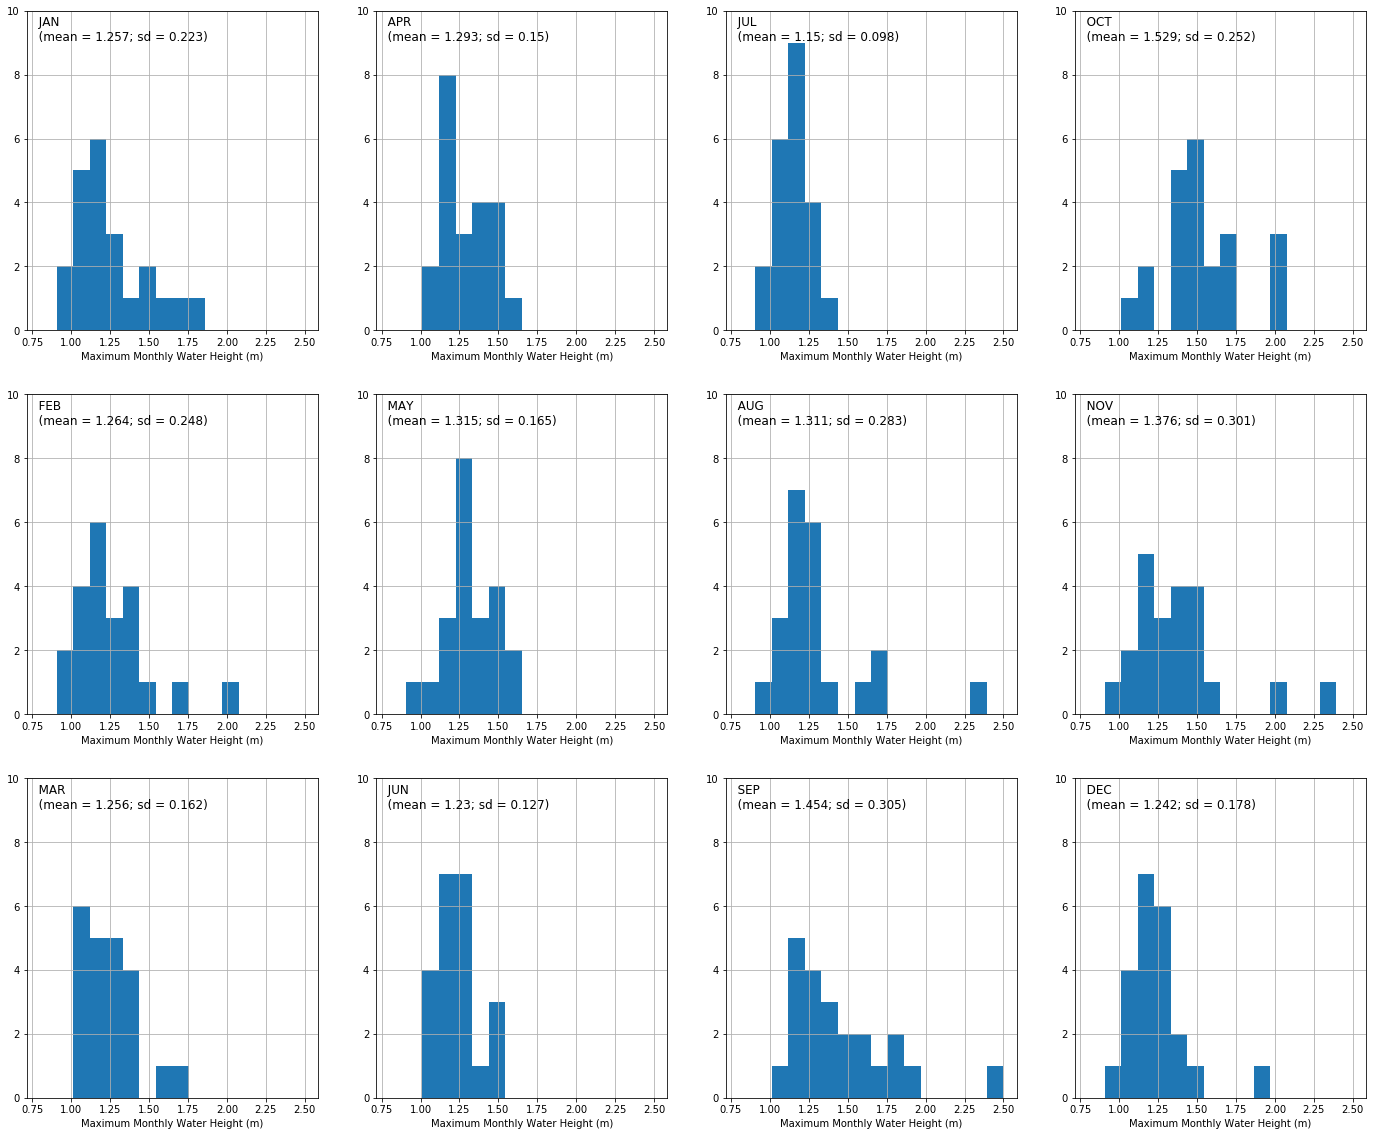

In [138]:
# Histograms and stats on water level data for all 12 months (1996-2017)
months = list(wlev_clean_df.columns[1:])
hist_pos = [1,5,9,2,6,10,3,7,11,4,8,12]

fig=plt.figure(figsize=(24,20))

for m in range(len(months)):
    
    # monthly stats
    this_data = wlev_clean_df.iloc[:,m+1]
    this_mean = np.around(np.mean(this_data),decimals=3)
    this_std = np.around(np.std(this_data),decimals=3)

    # plot it up
    ax=fig.add_subplot(3,4,hist_pos[m])    
    this_data.hist(bins=16,ax=ax,range=(0.80,2.5))
    ax.set_ylim(0,10.0)
    ax.set_title('   '+months[m]+'\n   (mean = '+str(this_mean)+'; sd = '+str(this_std)+')',\
                 loc='left', pad=-30)
    ax.set_xlabel('Maximum Monthly Water Height (m)')

plt.show()


#### Southern Oscillation Index histogram

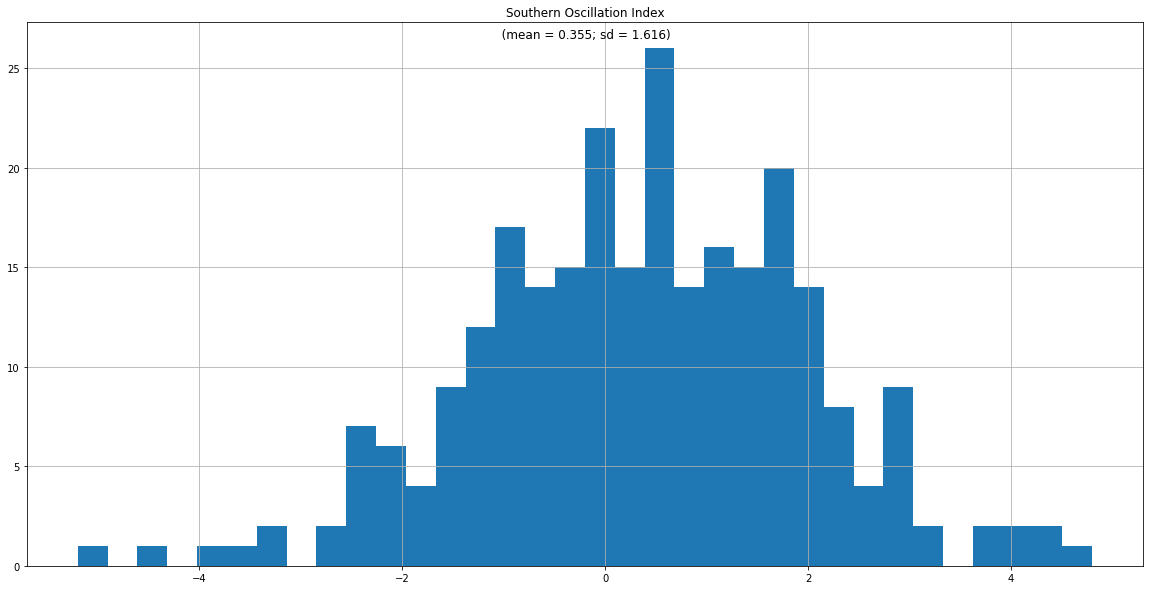

In [139]:
# Histogram and stats for *all* SOI data
# (first restructure dataframe to facilitate this analysis)
#
hist_soi_values=soi_df.iloc[:,1:].values
hist_soi_df=pd.DataFrame(
    {'Southern Oscillation Index':list(hist_soi_values.flatten())}
)

# stats
this_data = hist_soi_df.iloc[:,:]
this_mean = np.around(np.mean(this_data),decimals=3)
this_std = np.around(np.std(this_data),decimals=3)

# plot histogram and stats
hist_soi_df.hist(bins=34,figsize=(20,10))
plt.text(-0.25,26.5,'   (mean = '+str(this_mean[0])+'; sd = '+str(this_std[0])+')',fontsize='12',\
         horizontalalignment='center')

plt.show()

### Lagged datasets: 

    a) One of our goals is to consider the time-lagged nature of the relationship between ENSO dynamics and water 
    level in Norfolk. We will examine lags (in Southern Oscillation Index) out to 22 months in increments of 2 
    using a for loop. 
    
    b) First, we'll construct our lagged datasets.
    
    c) Then, we'll generate scatterplots and correlations at the twelve lags to see if any patterns are apparent.

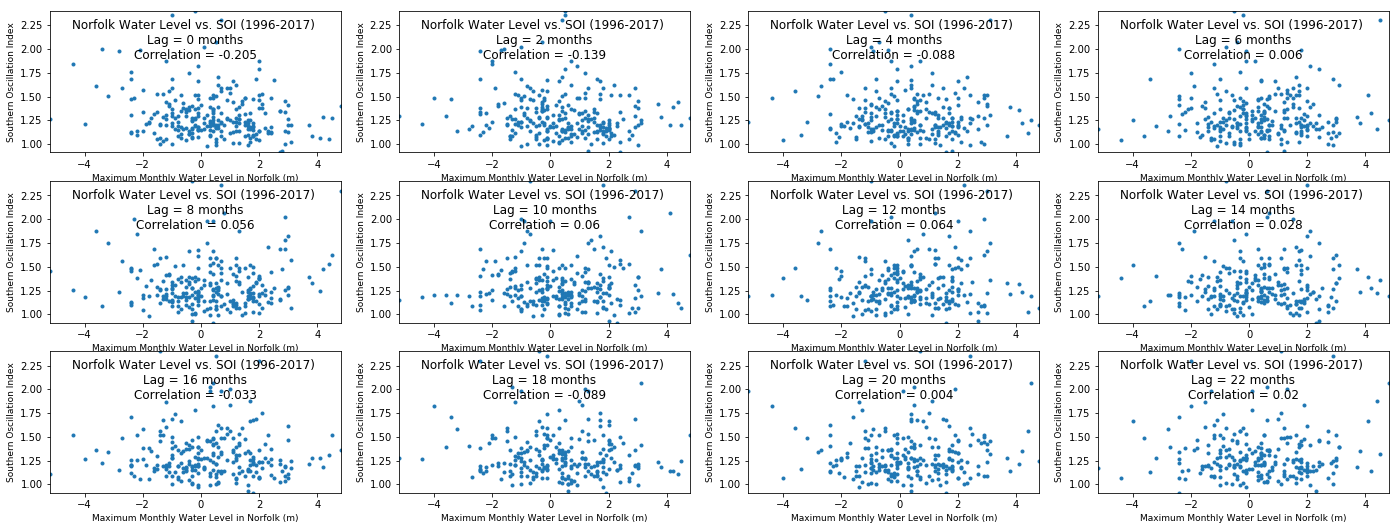

In [140]:
# Scatterplots of Norfolk water level vs. SOI
fig=plt.figure(figsize=(24,12))

min_year = 1996
max_year = 2017

lag_list = []
lag_step = 2
num_lags = 12

for s in range(num_lags):
    lag_list.append(s * lag_step)

soi_lag_0 = soi_df.iloc[:,1:].values.flatten()
wlev_lag_0 = wlev_clean_df.iloc[:,1:].values.flatten()

xrange=(np.min(soi_lag_0),np.max(soi_lag_0))
yrange=(np.min(wlev_lag_0),np.max(wlev_lag_0))

for lag in lag_list:
    ax=fig.add_subplot(4,4,(lag/lag_step)+1)
    
    this_lag_soi_data = soi_lag_0[0:(len(soi_lag_0)-lag)]
    this_lag_wlev_data = wlev_lag_0[(0+lag):]

    x = this_lag_soi_data
    y = this_lag_wlev_data
    r = np.around(np.corrcoef(x,y)[1,0],decimals=3)
        
    plt.scatter(x,y,marker='.')

    ax.set_xlim(xrange)
    ax.set_ylim(yrange)
    
    plt.title('Norfolk Water Level vs. SOI ('+str(min_year)+'-'+str(max_year)+') \nLag = '+str(lag)+\
              ' months\nCorrelation = '+str(r), pad=-48)
    plt.xlabel('Maximum Monthly Water Level in Norfolk (m)', fontsize=9)
    plt.ylabel('Southern Oscillation Index', fontsize=9)

plt.show()

### Finding #1: There is a negative correlation at lags 1 - 3 (0 - 4 months) between SOI and maximum monthly water level at Sewell's Point in Norfolk; this is the expected sign based on what we know about the atmospheric/oceanic phenomena described in the introduction. 
### Linear regression of water level vs. SOI at lag = 0 confirms a negative slope. The large intercept (~1.3 m above the gauge's reference level) is likely indicative of our use of monthly maxima to quantify water levels:


In [141]:
reg_fit = np.polyfit(soi_lag_0,wlev_lag_0,1)
m = reg_fit[0]
b = reg_fit[1]


print('Slope of regression fit:\t',m)
print('Intercept:\t\t\t',b)

Slope of regression fit:	 -0.030471678589686545
Intercept:			 1.3172774373170937


### Finding #2: This correlation mostly gets weaker over time, and appearing to settle at around zero. This is contrary to our expectation that there would be clearer evidence of a time delay between ENSO correlates and water level in Norfolk. 

### Let's now see how the data cluster using k-means. Perhaps the clusters will help further explain patterns in our dataset.

In [142]:
# Combine SOI and water level data into a single dataframe
soi_wlev_df = pd.DataFrame(
    {'SOI' : soi_lag_0,
     'WLEV' : wlev_lag_0,
    })
soi_wlev_df.head()

,SOI,WLEV
0,1.6,1.251
1,0.4,1.374
2,1.9,1.053
3,1.3,1.134
4,0.5,1.167


#### Generate clusters

In [143]:
from sklearn.cluster import KMeans
from sklearn import metrics

num_clusters = list(range(2,50))
silhouette_coeffs = []

for c in num_clusters:
    kmeans_model = KMeans(n_clusters=c, random_state=42).fit(soi_wlev_df)
    labels = kmeans_model.labels_
    silhouette_coeffs.append(metrics.silhouette_score(soi_wlev_df, labels, metric='euclidean'))

#### Plot silhouette coefficient vs number of clusters to help select number to retain 

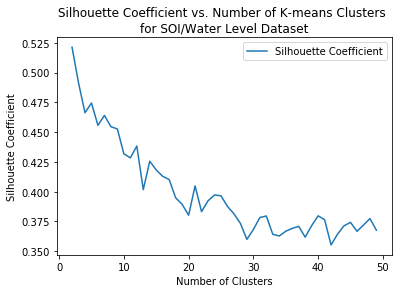

In [144]:
x = num_clusters
y = silhouette_coeffs

plt.plot(x,y,'-', label='Silhouette Coefficient')
plt.title('Silhouette Coefficient vs. Number of K-means Clusters \nfor SOI/Water Level Dataset')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Coefficient')
plt.legend()

plt.show()

#### 30 clusters seems an appropriate number to retain;  however, let's create a function to make it easier to look at different numbers of clusters

In [145]:
def plot_clusters():
    date_labels = []
    month_strings = soi_df.columns[1:]
    num_months = len(month_strings)
    #
    min_year = 1996
    max_year = 2017
    num_years = max_year - min_year + 1
    #
    for year in range(1996,2018):
        for month in month_strings:
            date_labels.append(month+'-'+str(year))
    markers=['.',',','o','v','^','<','>','1','2','3','4','8','s','p','P','*','h','H','+','x','X','D','d']
    colors = ['xkcd:grey','xkcd:red','xkcd:orange','xkcd:yellow','xkcd:olive green','xkcd:green',\
              'xkcd:forest green','xkcd:teal','xkcd:cyan','xkcd:blue','xkcd:indigo','xkcd:violet']

    fig = plt.figure(figsize=(36,24))

    # Axes
    axes = plt.gca()

    # Plot cluster membership for all month-year combinations
    for i in range(len(date_labels)):
        x = date_labels[i]
        y = cluster_centroids[i]

        plt.scatter(x,y,color=colors[i%num_months],marker=markers[i%num_years], s=150)
        plt.annotate(x, (x, y), fontsize=13, rotation=90)

    # Turn off x-axis tick labels
    axes.set_xticklabels([])

    plt.title('Membership for K-Means Clustering of the SOI/Water Level Dataset', fontsize=22)
    plt.ylabel('Cluster Number',fontsize=22)

    plt.show()

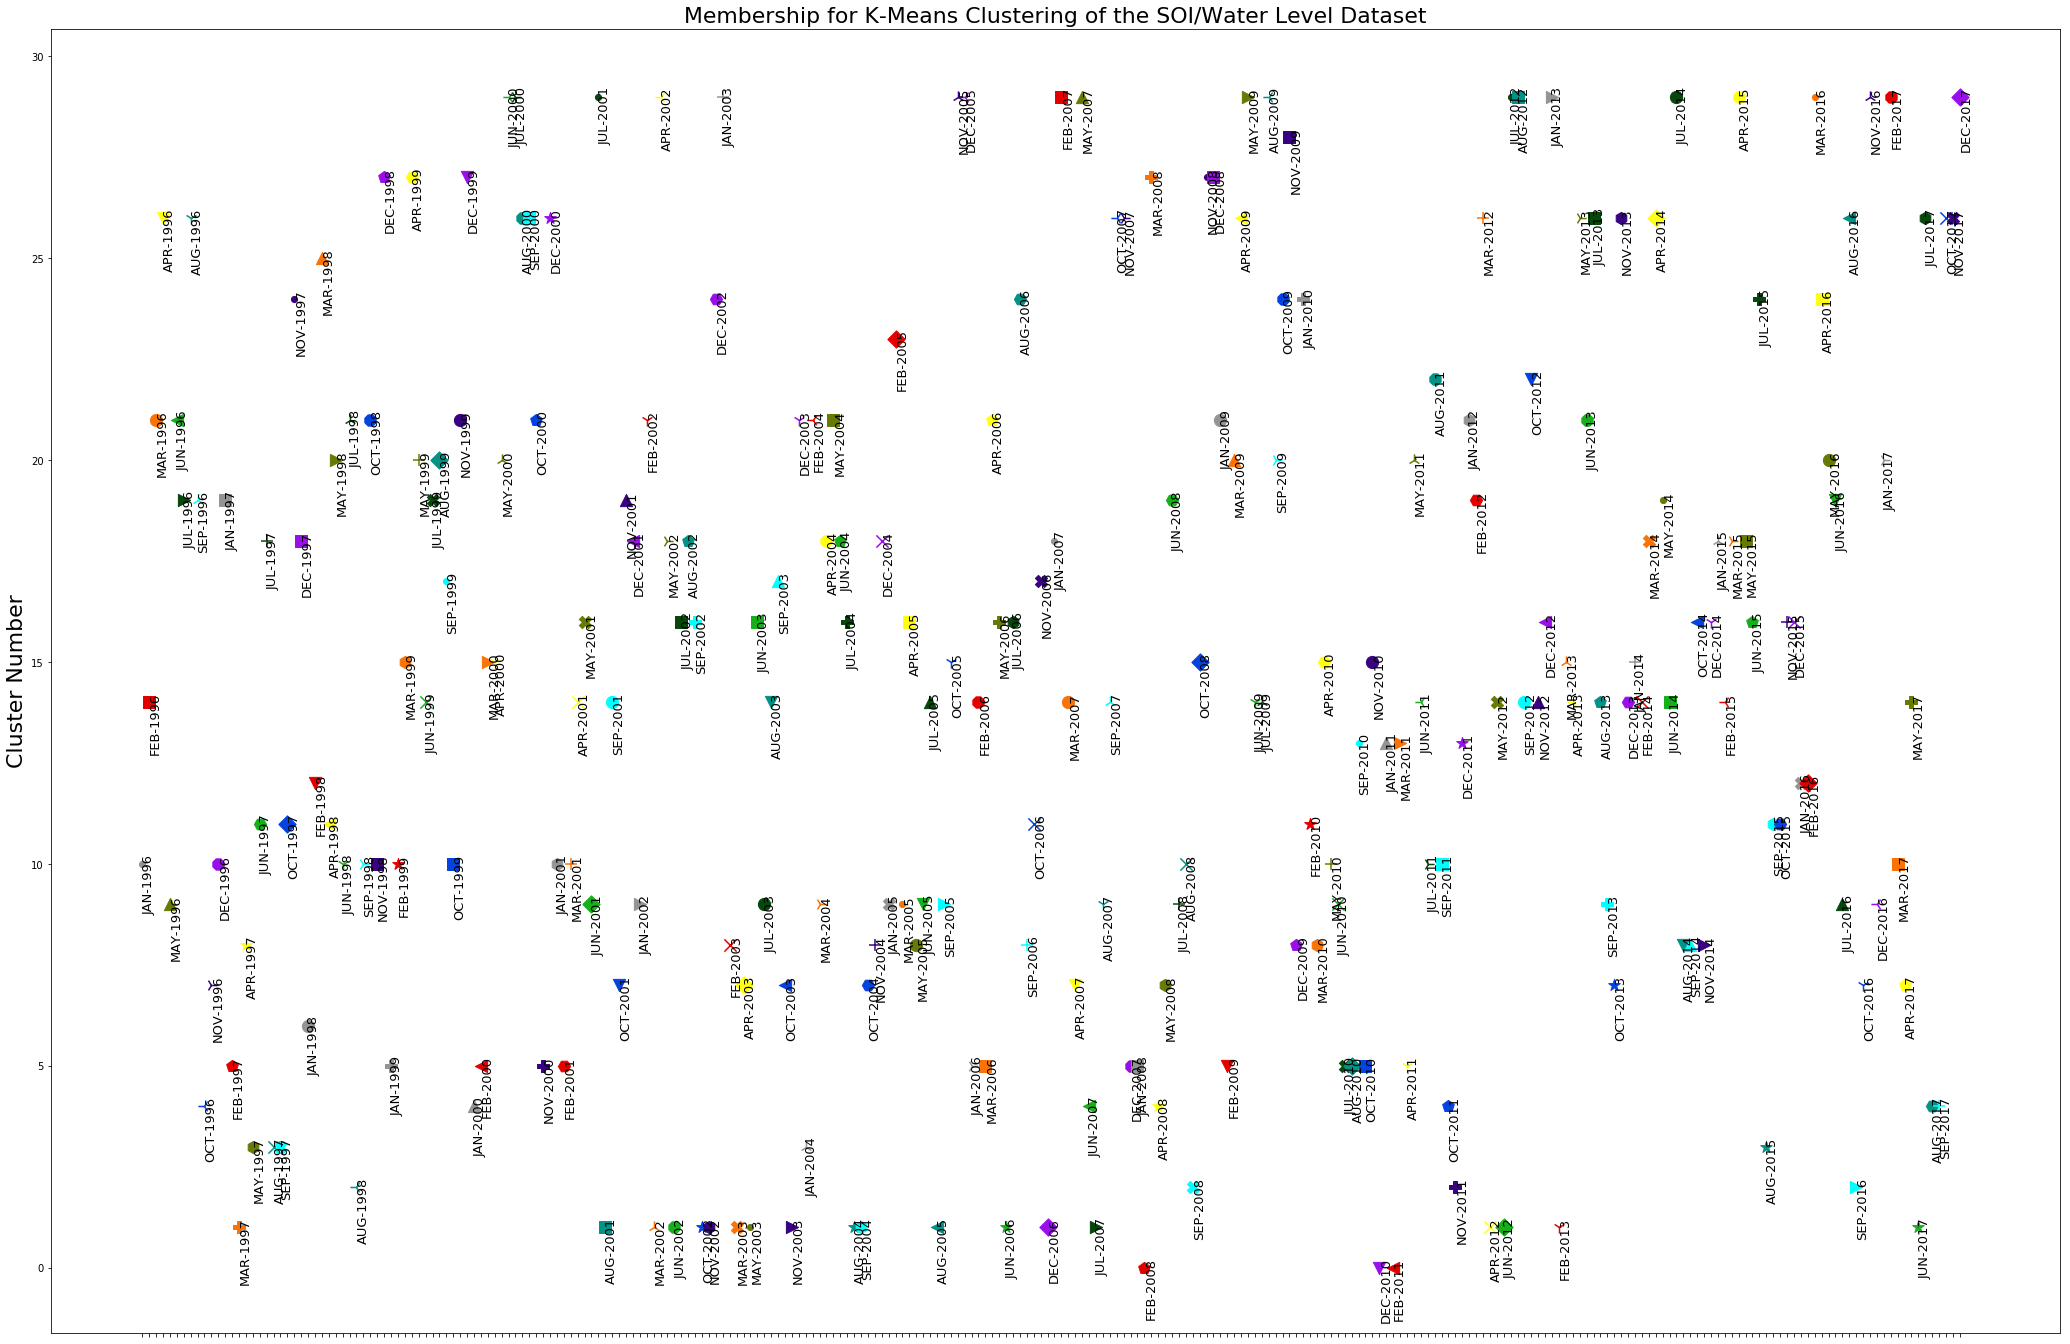

In [146]:
cluster_centroids = KMeans(n_clusters=30, random_state=42).fit_predict(soi_wlev_df)
plot_clusters()

#### Here, months are color-coded, and years are encoded by different plotting markers

#### This does not seem to add much to what we've already seen, so lets cut back on the number of clusters to something more manageable. From the above plot of silhouette coefficient, it appears 20 might also be a reasonable number of clusters to retain.

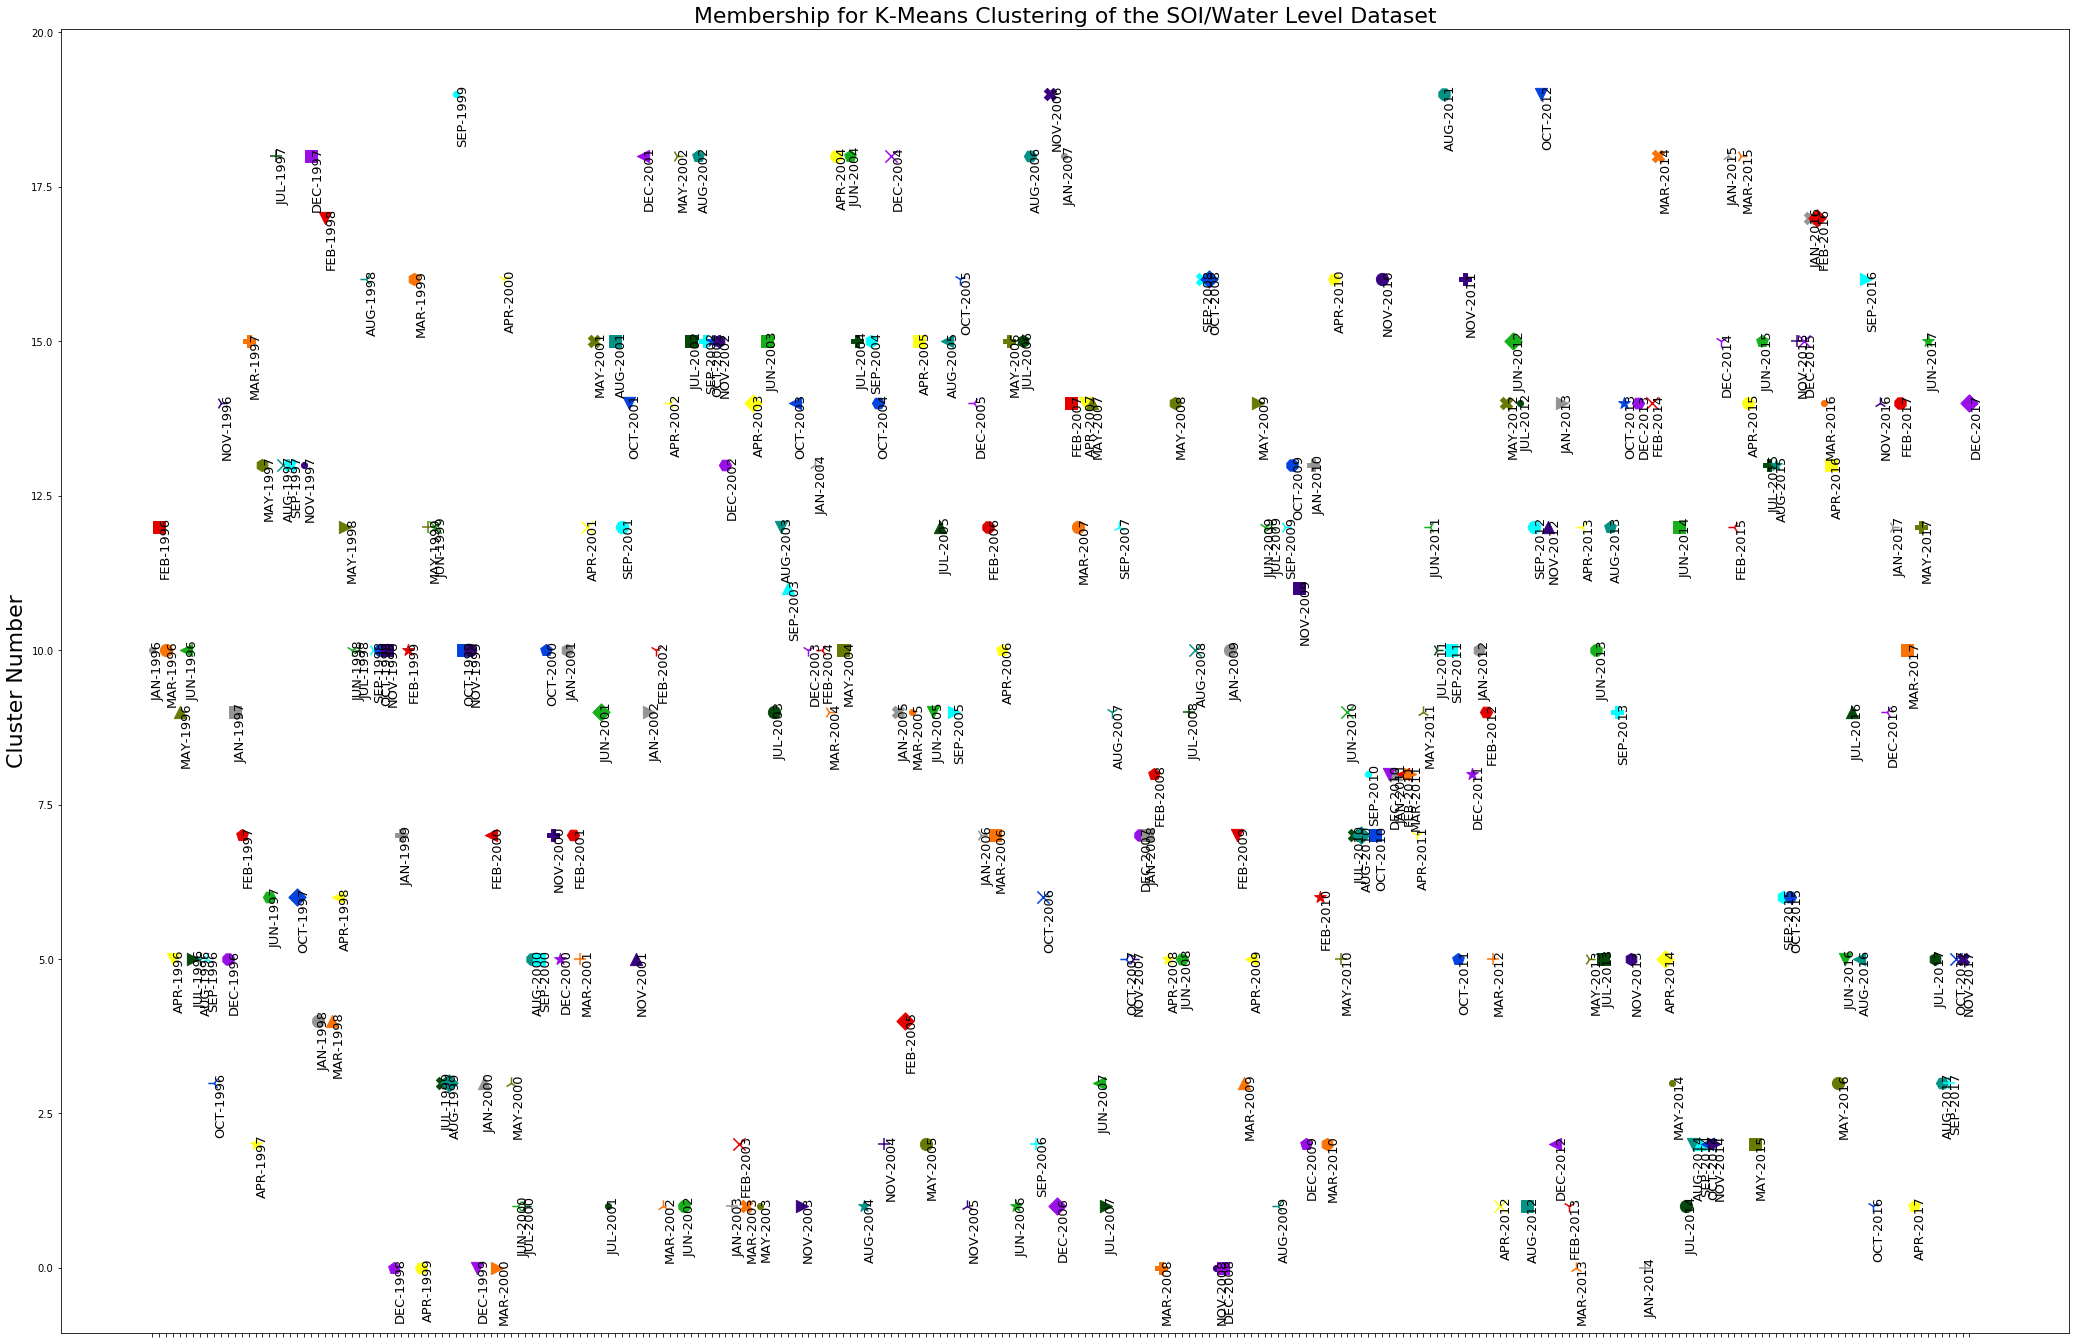

In [147]:
cluster_centroids = KMeans(n_clusters=20, random_state=42).fit_predict(soi_wlev_df)
plot_clusters()

#### This is a little more interpretable, but still difficult to see any obvious patterns

#### We'll try one more run; this time with just 3 clusters (ideally, we'll see 1 cluster correspond to each of the 3 phases, El Niño, La Niña, and neutral)

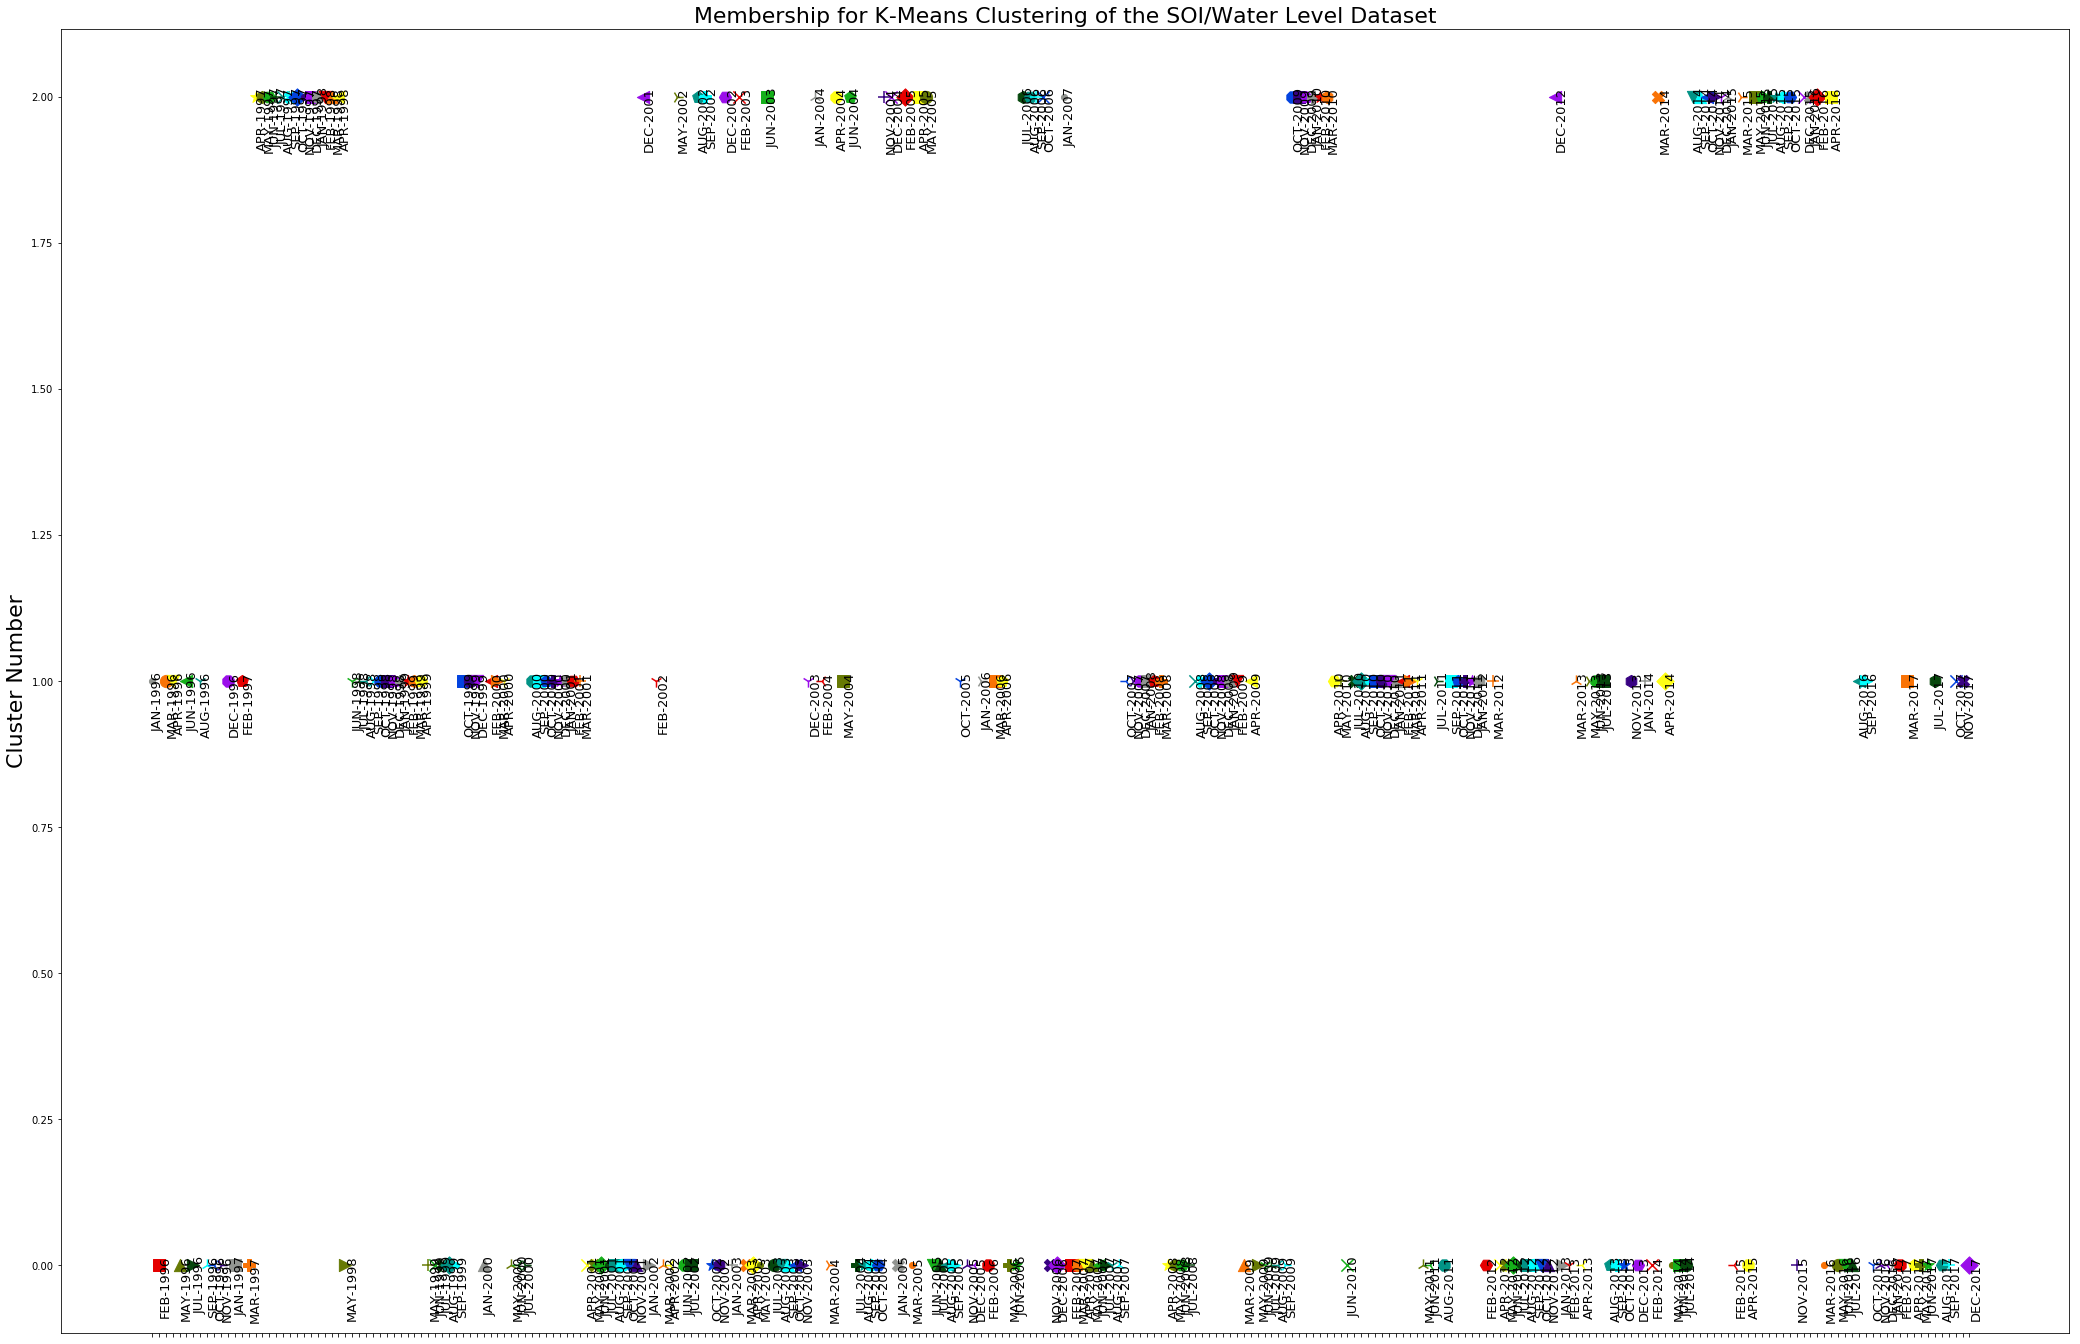

In [148]:
cluster_centroids = KMeans(n_clusters=3, random_state=42).fit_predict(soi_wlev_df)
plot_clusters()

#### This is *much* more interpretable, so let's see if these groupings comport with actual ENSO cycles:

#### We also know the timings of official ENSO events over the period of interest. Below is a link to a table of historical monthly Oceanic Niño Index (ONI) data. The ONI is an alternative metric to SOI for quantifying ENSO activity, and it consists of monthly sea-surface temperature anomalies in a defined region of the South Pacific:

<http://origin.cpc.ncep.noaa.gov/products/analysis_monitoring/ensostuff/ONI_v5.php>



#### Based on this table, it appears that the data are mostly clustering into the three ENSO phases:

* Cluster 0: neutral
* Cluster 1: La Niña
* Cluster 2: El Niño


### Finding #3: Even with only 3 groupings, cluster labeling is still up to user interpretation. In this case, the El Niño cycle separated out pretty well, but the other clusters were less consistent. This is likely due to two factors:

1. The ENSO cycle's amplitude is asymmetric, with the La Niña phase weaker in general
2. The water-level data at Norfolk are subject to additional (non-ENSO) effects that likely serve to complicate the temporal signal.

## Discussion and Conclusions

The negative correlation, at short lags, between SOI and water level at Norfolk was to be expected; however, the correlation was weak, and tailed off as lags increased from zero. This was a bit surprising, but not terribly so, as the sample sizes were a bit limited. I believe that results might be closer to expectations if we looked at a longer time series, and used more stations around Norfolk. The complicating factors here are that the present gauge installation only goes back to December, 1995 (hence our period of record begins in January 1996), and NOAA presently maintains a small number of water-level gauges in the Norfolk vicinity. The first issue -- instrument changeover -- can probably be ameliorated by performing some kind of calibration between old & new sensors, but the small number of available stations seems to be a more challenging problem. There may be additional gauges in the area not maintained by NOAA, so this would be an area of further inquiry.

The clustering exercise -- like any unsupervised method -- includes no guarantees of interpretability or suitability. In the present study, we saw that even a drastic reduction in the number of clusters (as compared to the apparent optimal value) does not guarantee homogenous, meaningful groupings. There may be an intermediate number of clusters (i.e., between 3 and 20) that would be more suitable than the examples presented here, but these runs made sense given a) what the silhouette coefficient plot indicated; and b) what the results suggested. 

Ultimately, the ability to predict water levels in locations like Norfolk that have frequent flooding events (both storm-induced and tidal) is clearly a useful goal. Accurate. flood forecasts would allow policymakers, business owners, the military, and residents to plan better, for these events, and would lead to greater community resilience throughout the region.
